In [91]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
from scipy.integrate import simpson, romberg, trapezoid, quad
from sympy import legendre, symbols, diff, expand, factor, simplify
from scipy.special import legendre as legendre_scipy
from scipy.special import roots_legendre
from scipy.integrate import fixed_quad
from scipy.optimize import fsolve, bisect, newton, root_scalar

# Actividad 07: Integración

---
### Profesor: Juan Marcos Marín
### Nombre:Leonardo Ortega Trujillo

*Métodos computacionales 2024-II*

---

#1
* Implemente una función para el **método de integración de Romberg** definiendo un límite de tolerancia de 1e-8 y/o un máximo de iteraciones de 10.

* Encuentre la integral para

$$\int_0^{\pi/4} dx\, e^{3x}\cdot \sin(x)$$

* Imprima su resultado y compare los valores dados por `scipy.integrate.romberg`

* Finalmente, encuentre el valor del error, hallando el valor exacto usando `sympy`



#Metodo de Romberg
$$
T(h) \approx \frac{h}{2} \left[ f(a) + 2 \sum_{i=1}^{n-1} f(x_i) + f(b) \right] -\frac{b − a}{12}h^2f''(\xi)
$$


In [46]:
def Romberg(f, a, b, n):
    #n  : número de niveles de refinamiento, tamaño de la matriz de romberg
    R = np.zeros((n, n))

    #paso inicial usando la regla del trapecio
    h = b - a
    R[0, 0] = (h / 2) * (f(a) + f(b))

    #tabla de Romberg
    for i in range(1, n):
        h /= 2  # Reducimos el tamaño del paso a la mitad
        sumatoria = sum(f(a + k * h) for k in range(1, 2**i, 2))
        R[i, 0] = 0.5 * R[i-1, 0] + h * sumatoria  # Regla del trapecio refinada

        # Extrapolación de Richardson
        for j in range(1, i + 1):
            R[i, j] = (4**j * R[i, j-1] - R[i-1, j-1]) / (4**j - 1)

    return R

In [21]:
a , b = 0, np.pi/4
f = lambda x: np.exp(3*x) * np.sin(x)

M = Romberg(f,a,b,10)

print(romberg(f, a, b, show=True), M)

Romberg integration of <function vectorize1.<locals>.vfunc at 0x794ad8758040> from [0, 0.7853981633974483]

 Steps  StepSize   Results
     1  0.785398  2.929727 
     2  0.392699  1.952999  1.627423 
     4  0.196350  1.684140  1.594520  1.592326 
     8  0.098175  1.615224  1.592253  1.592101  1.592098 
    16  0.049087  1.597887  1.592107  1.592098  1.592098  1.592098 
    32  0.024544  1.593545  1.592098  1.592098  1.592098  1.592098  1.592098 

The final result is 1.592097707858613 after 33 function evaluations.
1.592097707858613 [[2.929727   0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.95299932 1.62742343 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.68413976 1.5945199  1.59232633 0.         0.         0.
  0.         0.         0.         0.        ]
 [1.61522435 1.59225255 1.59210139 1.59209782 0.         0.
  0.         0.         0.         0.        ]
 [1.59788667 1.59210744 1.59209

<ipython-input-21-4b0761c9056e>:6: DeprecationWarning: `scipy.integrate.romberg` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  print(romberg(f, a, b, show=True), M)


#2

* Usando los *métodos trapezoidal compuesto*, *simpson 1/3* y de *medio punto* encuentre la siguiente integral,

$$\int_e^{1+e} dx\, \frac{1}{x\ln x}$$

* Luego, haga un estudio de la convergencia en términos del valor de $h$ o de los sub-intervalos de la función. ¿Cuál es mejor?


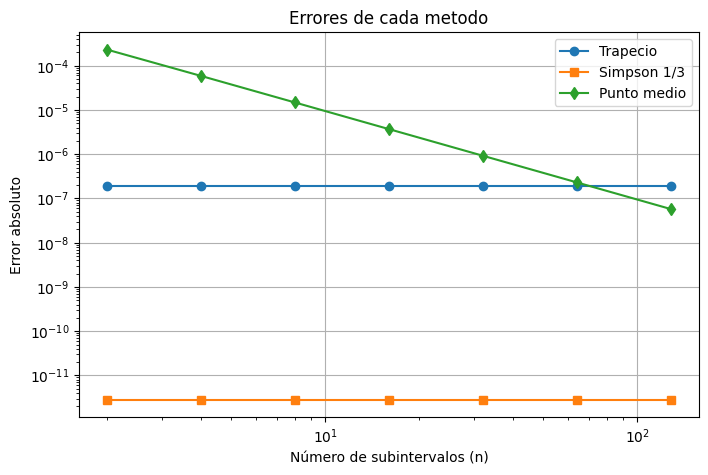

In [57]:
g = lambda x: 1 / x*np.log(x)
c,d = np.e, np.e + 1
x = np.linspace(c,d,100)

def punto_medio_compuesto(f, a, b, n):
    h = (b - a) / n
    x_medio = np.linspace(a + h/2, b - h/2, n)
    return h * np.sum(f(x_medio))

Int_ref = quad(g, c, d)[0]

n_values = np.array([2, 4, 8, 16, 32, 64, 128])

#errores
error_trapecio = []
error_simpson = []
error_punto_medio = []

for n in n_values:
    I_trap = trapezoid(g(x),x)
    I_simp = simpson(g(x),x=x)
    I_pm = punto_medio_compuesto(g, c, d, n)

    error_trapecio.append(abs(I_trap - Int_ref))
    error_simpson.append(abs(I_simp - Int_ref))
    error_punto_medio.append(abs(I_pm - Int_ref))

plt.figure(figsize=(8, 5))
plt.plot(n_values,error_trapecio,'o-', label ='Trapecio' )
plt.plot(n_values,error_simpson,'s-',label="Simpson 1/3")
plt.plot(n_values,error_punto_medio,'d-',label="Punto medio")
plt.yscale('log')
plt.xscale('log')
plt.title('Errores de cada metodo')
plt.xlabel("Número de subintervalos (n)")
plt.ylabel("Error absoluto")
plt.legend()
plt.grid()
plt.show()

#Conclusión:
El metodo con menor error es el metodo de simpson1/3, su error se mantiene estable a medida que el número de subintervalos crece. El metodo de trapecio igualmente tiene un error estable pero mayor al de simpsons1/3, y finalmente el metodo de punto medio tiene un error mayor y necesita de un numero de intervalos más grande que los otros dos para disminuir su error.

#3
Usando la siguiente función:



```python
def gauss_quad_standard(func, n):
    """
    Calcula la integral de una función en el intervalo [-1, 1]
    utilizando cuadratura gaussiana.

    Parameters:
    - func: La función a integrar.
    - n: Número de puntos para la cuadratura (grado del polinomio de Legendre).

    Returns:
    - Aproximación de la integral.
    """
    # Obtener raíces y pesos del polinomio de Legendre
    x, w = roots_legendre(n)

    # Evaluar la suma ponderada
    integral = np.sum(w * func(x))
    return integral
```

Modifique la función `gauss_quad_standard` de forma tal que no este restringida para $[-1,1]$ sino para cualquier intervalo $[a,b]$. Luego, encuentre la integral del *punto 2*.





In [75]:
def gauss_quad(func, a, b, n):
    """
    Calcula la integral de una función en un intervalo [a, b] usando cuadratura gaussiana.

    Parameters:
    - func: La función a integrar.
    - a, b: Límites de integración.
    - n: Número de puntos de cuadratura (grado del polinomio de Legendre).

    Returns:
    - Aproximación de la integral.
    """
    # Obtener raíces y pesos del polinomio de Legendre
    x, w = roots_legendre(n)

    # Cambio de variable: Escalar los puntos de Gauss al intervalo [a, b], parametrizacion para el intervalo [-1,1]
    t = (b - a) / 2 * x + (a + b) / 2

    # Evaluar la integral transformada
    integral = (b - a) / 2 * np.sum(w * func(t))

    return integral


#calculo de la integral del 2do punto comparada con el metodo de scipy
np.isclose(gauss_quad(g,c,d,15), fixed_quad(g, c, d, n=n)[0])

True

#4

Encuentra todas las raices para los polinomios de grado 3 y 4 de **Legendre** usando el Método de la Secante y Newton-Raphson.



```python
import sympy as sp
x = sp.Symbol('x')

# Polinomio de Legendre de grado n
Pn = sp.legendre(n, x)

```

y calcule los pesos $w_i$ de la cuadratura mediante la fórmula:
   $$
   w_i = \frac{2}{(1 - x_i^2) \left[P_n'(x_i)\right]^2},
   $$
   donde $P_n'(x)$ es la derivada del polinomio de Legendre $P_n(x)$.


In [119]:
x = sp.Symbol('x')

# Polinomio de Legendre de grado 3 y 4
Pn_3 = sp.legendre(3, x)
Pn_4 = sp.legendre(4, x)

Pn_3_func = sp.lambdify(x,Pn_3,'numpy')
Pn_4_func = sp.lambdify(x,Pn_4,'numpy')

#raices de los polinomios de Legendre
raiz_N_Pn3 = newton(Pn_3_func,1.5)
raiz_S_Pn3 = root_scalar(Pn_3_func, x0 = 1.5, method = 'secant')

raiz_N_Pn4 = newton(Pn_4_func,1.5)
raiz_S_Pn4 = root_scalar(Pn_4_func, x0 = 1.5, method = 'secant')

#derivada
Pn_3_prime = sp.diff(Pn_3,x)
Pn_4_prime = sp.diff(Pn_4,x)

Pn_3_prime_func = sp.lambdify(x,Pn_3_prime,'numpy')
Pn_4_prime_func = sp.lambdify(x,Pn_4_prime,'numpy')

#calculo de los pesos w
w_3 = 2 / ((1 - raiz_N_Pn3)*(Pn_3_prime_func(raiz_N_Pn3))**2)
w_4 = 2 / ((1 - raiz_N_Pn4)*(Pn_4_prime_func(raiz_N_Pn4))**2)

print(f'Las raíces para el polinomio de Legendre de grado 3 y 4 son respectivamente : {w_3} y {w_4}')

Las raíces para el polinomio de Legendre de grado 3 y 4 son respectivamente : 0.9858870384674903 y 0.6474052834492414
